# INPE Downloader

This notebook shows the basic usage of the INPE Downloader package.<br>
At version 0.1.1, this package manages to download MERGE files (.GRIB2) from INPE.<br>
The files can be automatically converted from .GRIB2 to GEOTiff with correct CRS (the original file lacks the CRS and the longitude is from 0 to 360).<br>

The files are located at `ftp.cptec.inpe.br`

In [17]:
%load_ext autoreload
%autoreload 2

from raindownloader.inpe import INPEDownloader, INPE
from raindownloader.utils import FileType

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Create a downloader instance
downloader = INPEDownloader(server=INPE.FTPurl, root=INPE.DailyMERGEroot)

## Download a single file

To download a single file, we can simply pass the date in any format that dateutil can parse.<br>
For example: 'yyyy-mm-dd', 'yyyymmdd', 'yyyy/mm/dd', etc.

In [3]:
file = downloader.download_file('2023-03-02', local_folder='../tmp')
assert file.exists()

file ../tmp/MERGE_CPTEC_20230302.grib2 already exists.


In [4]:
file

PosixPath('../tmp/MERGE_CPTEC_20230302.grib2')

<b>NOTE: </b> One should keep in mind that the rain from 9:00am from 2023/03/01 to 9:00 from 2023/03/02 is saved as 20030302 but it is actually the amount of rain in 20230301.

Before downloading, we check if the file exists and if it is exactly the same (size and modified dates). In this case, we don't download it again, unless `force` is set to True.

In [5]:
file = downloader.download_file('2023-03-02', local_folder='../tmp')


file ../tmp/MERGE_CPTEC_20230302.grib2 already exists.


## Download a range

Similar to download a file, we can download a range by passing start and end dates...


In [6]:
files = downloader.download_range(start_date='20230301', end_date='20230302', local_folder='../tmp', force=False)

# assert files exist
for file in files:
    assert file.exists()

file ../tmp/MERGE_CPTEC_20230301.grib2 already exists.
file ../tmp/MERGE_CPTEC_20230302.grib2 already exists.


In [7]:
files

[PosixPath('../tmp/MERGE_CPTEC_20230301.grib2'),
 PosixPath('../tmp/MERGE_CPTEC_20230302.grib2')]

## Downloading as GEOTiff

Passing `file_type = FileType.GEOTIFF` to any download method will force a post-processing that converts the original `.GRIB2` file to `.TIF`, correcting the longitude to -180 +180 and setting the CRS to <b>EPSG:4326</b>.

<b>Note:</b> In this case, the original `GRIB2` file is kept in the local folder, otherwise it would not be possible to check if it is already downloaded.

In [23]:
file = downloader.download_file('20230301', local_folder="../tmp", file_type=FileType.GEOTIFF)

In [24]:
file

PosixPath('../tmp/MERGE_CPTEC_20230301.tif')

In [25]:
file.exists()

True

In [9]:
tif = INPEDownloader.grib2tif(file)

In [10]:
tif

PosixPath('../tmp/MERGE_CPTEC_20230302.tif')

In [11]:
import rioxarray as xrio

In [12]:
ds = xrio.open_rasterio(tif)

In [13]:
ds

<xarray.DataArray (band: 1, y: 924, x: 1001)>
[924924 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
Attributes: (12/32)
    AREA_OR_POINT:                            Area
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           prec
    GRIB_dataType:                            an
    GRIB_gridDefinitionDescription:           Latitude/longitude. Also called...
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_units:                               kg m**-2
    long_name:                                Precipitation
    standard_name:                            unknown
    units:                                    kg m**-2
    scale_factor:                             1.0
    add_offset:                               0.0

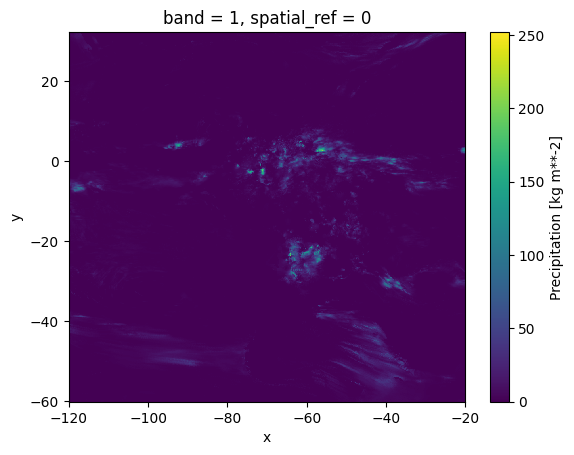

In [14]:
ds.plot()

In [26]:
import geopandas as gpd
import contextily as cx

In [27]:
world_path = gpd.datasets.get_path('naturalearth_lowres')

In [28]:
world = gpd.read_file(world_path)
world.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


In [30]:
import rasterio as rio

In [31]:
chuva = rio.open(file)

In [32]:
chuva.read_transform()

[-120.10000000000001, 0.1, 0.0, -60.099999999999994, 0.0, 0.09999999999999999]

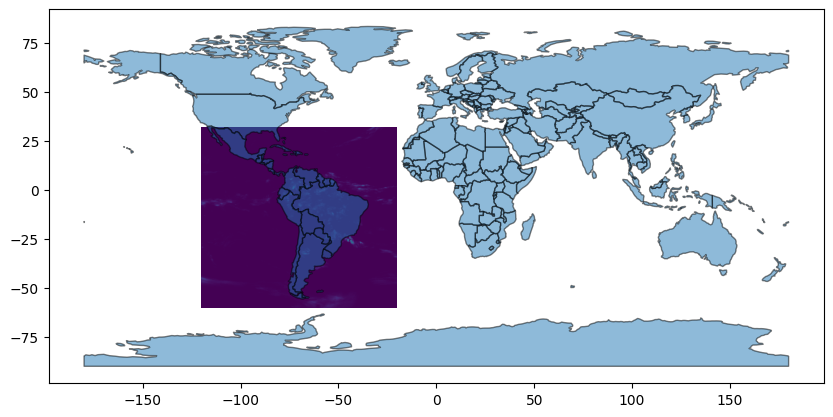

In [46]:
ax = world.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=file, crs=chuva.crs, reset_extent=False)

In [42]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
chuva.crs

CRS.from_epsg(4326)

In [41]:
chuva.window_bounds()

TypeError: window_bounds() missing 1 required positional argument: 'window'

In [37]:
world.bounds

,minx,miny,maxx,maxy
0,-180.000000,-18.287990,180.000000,-16.020882
1,29.339998,-11.720938,40.316590,-0.950000
2,-17.063423,20.999752,-8.665124,27.656426
3,-140.997780,41.675105,-52.648099,83.233240
4,-171.791111,18.916190,-66.964660,71.357764
...,...,...,...,...
172,18.829825,42.245224,22.986019,46.171730
173,18.450017,41.877551,20.339800,43.523840
174,20.070700,41.847110,21.775050,43.272050
175,-61.950000,10.000000,-60.895000,10.890000


## Opening the rain GRIB

In [7]:
import xarray as xr

In [9]:
ds = xr.open_dataset(file)

In [12]:
ds.assign_coords(longitude=ds.longitude - 360)

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-03-08T17:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
from enum import Enum, auto
class Color(Enum):
    RED = auto()
    GREEN = auto()
    BLUE = auto()


In [16]:
color = Color.RED

In [26]:
color.GREEN.value

2

In [22]:
color == Color.RED

False